<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pwd

/content/gdrive/My Drive/FinRL-test


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import importlib

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor import fixed_yahoodownloader # comment this if you chose other path above
importlib.reload(fixed_yahoodownloader) # comment this if you chose other path above
from finrl.meta.preprocessor.fixed_yahoodownloader import YahooDownloader #comment this if you chose the other path above

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLEnsembleAgent
from finrl.agents.stablebaselines3.single_models import DRLSingleAgent
from finrl.agents.stablebaselines3.modified_pets_model import ModifiedPETSAgent
from finrl.agents.stablebaselines3.mbrl_model import MBRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2024-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (104573, 8)
Display DataFrame:           date      close       high        low       open    volume  tic  day
0  2010-01-04  32.906178  41.099998  40.389999  40.810001   6894300  AXP    0
1  2010-01-05  32.833801  41.230000  40.369999  40.830002  10641200  AXP    1
2  2010-01-06  33.364552  41.669998  41.169998  41.230000   8399400  AXP    2
3  2010-01-07  33.905682  42.240002  41.110001  41.259998   8981700  AXP    3
4  2010-01-08  33.881458  42.480000  41.400002  41.759998   7907700  AXP    4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [8]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [9]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [12]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [13]:
rebalance_window = validation_window = 63

In [27]:
import pandas as pd
import numpy as np

models = ['A2C', 'PPO', 'DDPG', 'ensemble', 'MBRL', 'PETS', 'modified_PETS']
df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

df_account_value = pd.DataFrame()
sharpe_dict = {}

for model in models:
    df_model_value = pd.DataFrame()
    for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
        if model == 'PETS':
            # Unmodified PETS is in pets_only_results folder
            temp = pd.read_csv(f'pets_only_results/account_value_trade_PETS_{i}.csv')
        elif model == 'modified_PETS':
            # Modified PETS is in original_results folder but named as PETS
            temp = pd.read_csv(f'original_results/account_value_trade_PETS_{i}.csv')
        else:
            # Other models are in original_results folder under their own names
            temp = pd.read_csv(f'original_results/account_value_trade_{model}_{i}.csv')
        temp['model'] = model
        df_model_value = pd.concat([df_model_value, temp], ignore_index=True)
        
    # Focus on the last 504 days of this model
    # Make sure we have at least 504 data points per model before slicing
    if len(df_model_value) >= 504:
        # Calculate daily log returns
        # Shift forward one day and take log(price_t / price_{t-1})
        daily_values = df_model_value[-504:].account_value
        log_returns = np.log(daily_values / daily_values.shift(1)).dropna()
        # print(len(log_returns))
        # Compute Sharpe Ratio: (mean(log_returns) / std(log_returns)) * sqrt(252)
        sr = (log_returns.mean() / log_returns.std()) * (252 ** 0.5)
        sharpe_dict[model] = sr

        # Also store combined account values
        df_account_value = pd.concat([df_account_value, df_model_value], ignore_index=True)
    else:
        # If not enough data for 504 days, set Sharpe as NaN or skip
        sharpe_dict[model] = np.nan

# If you need separate DataFrames for each model joined with dates:
a2c_account_value = df_account_value[df_account_value['model']=='A2C'].join(df_trade_date[validation_window:].reset_index(drop=True))
ppo_account_value = df_account_value[df_account_value['model']=='PPO'].join(df_trade_date[validation_window:].reset_index(drop=True))
ddpg_account_value = df_account_value[df_account_value['model']=='DDPG'].join(df_trade_date[validation_window:].reset_index(drop=True))
ensemble_account_value = df_account_value[df_account_value['model']=='ensemble'].join(df_trade_date[validation_window:].reset_index(drop=True))
mbrl_account_value = df_account_value[df_account_value['model']=='MBRL'].join(df_trade_date[validation_window:].reset_index(drop=True))
pets_account_value = df_account_value[df_account_value['model']=='PETS'].join(df_trade_date[validation_window:].reset_index(drop=True))
modified_pets_account_value = df_account_value[df_account_value['model']=='modified_PETS'].join(df_trade_date[validation_window:].reset_index(drop=True))

# Return the Sharpe dictionary
sharpe_dict_2yr = sharpe_dict


In [28]:
import pandas as pd
import numpy as np

models = ['A2C', 'PPO', 'DDPG', 'ensemble', 'MBRL', 'PETS', 'modified_PETS']
df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

df_account_value = pd.DataFrame()
sharpe_dict = {}

for model in models:
    df_model_value = pd.DataFrame()
    for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
        if model == 'PETS':
            # Unmodified PETS is in pets_only_results folder
            temp = pd.read_csv(f'pets_only_results/account_value_trade_PETS_{i}.csv')
        elif model == 'modified_PETS':
            # Modified PETS is in original_results folder but named as PETS
            temp = pd.read_csv(f'original_results/account_value_trade_PETS_{i}.csv')
        else:
            # Other models are in original_results folder under their own names
            temp = pd.read_csv(f'original_results/account_value_trade_{model}_{i}.csv')
        temp['model'] = model
        df_model_value = pd.concat([df_model_value, temp], ignore_index=True)

    # Ensure we have at least 504 days of data
    if len(df_model_value) >= 504:
        # Focus on the last 504 days
        daily_values = df_model_value[-504:].account_value

        # Divide the 504 days into 8 quarters (63 days each)
        n_quarters = 8
        quarter_sharpes = []

        for quarter in range(n_quarters):
            start = quarter * 63
            end = start + 63
            quarter_values = daily_values[start:end]

            if len(quarter_values) < 2:
                continue  # Skip if insufficient data

            # Calculate daily log returns for this quarter
            log_returns = np.log(quarter_values / quarter_values.shift(1)).dropna()

            # Compute annualized Sharpe ratio for this quarter
            quarter_mean = log_returns.mean()
            quarter_std = log_returns.std()

            if quarter_std > 0:
                quarter_sharpe = (quarter_mean / quarter_std) * (252 ** 0.5)
                quarter_sharpes.append(quarter_sharpe)

        # Store the average annualized Sharpe ratio across all quarters
        if quarter_sharpes:
            avg_annual_sharpe = np.mean(quarter_sharpes)
        else:
            avg_annual_sharpe = np.nan

        sharpe_dict[model] = {
            'quarter_sharpes': quarter_sharpes,
            'average_annual_sharpe': avg_annual_sharpe
        }

        # Also store combined account values
        df_account_value = pd.concat([df_account_value, df_model_value], ignore_index=True)
    else:
        # If not enough data for 504 days, set Sharpe as NaN
        sharpe_dict[model] = {
            'quarter_sharpes': [],
            'average_annual_sharpe': np.nan
        }

sharpe_dict_quarter = sharpe_dict

In [ ]:
print(shapr)

In [ ]:
import pprint 
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(sharpe_dict_quarter)

In [31]:
pp.pprint(sharpe_dict_2yr)

{   'A2C': -0.35303081393825014,
    'DDPG': 0.0514989685206101,
    'MBRL': -0.2647352561519244,
    'PETS': 0.15819086020545248,
    'PPO': -0.03193223649508115,
    'ensemble': -0.0028456022368905103,
    'modified_PETS': -0.018188061536817755}


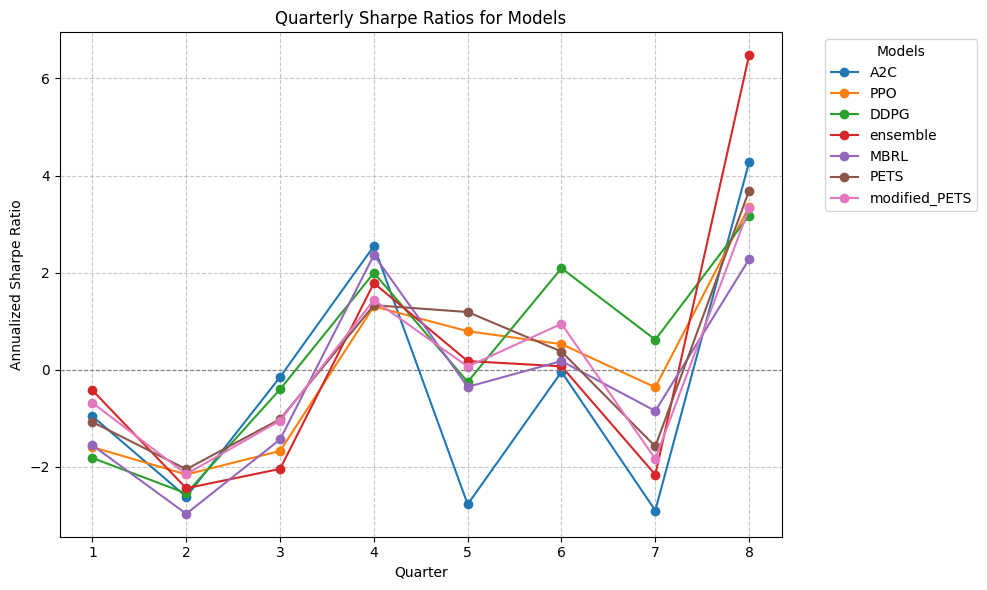

In [30]:
%matplotlib inline
# Extract data for plotting
quarters = list(range(1, 9))  # Quarter indices (1 to 8)
plt.figure(figsize=(10, 6))

# Plot Sharpe ratios for each model
for model, data in sharpe_dict_quarter.items():
    plt.plot(quarters, data['quarter_sharpes'], marker='o', label=model)

# Add labels, legend, and grid
plt.title("Quarterly Sharpe Ratios for Models")
plt.xlabel("Quarter")
plt.ylabel("Annualized Sharpe Ratio")
plt.xticks(quarters)  # Ensure x-axis ticks match quarter numbers
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)  # Add horizontal line at y=0 for reference
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Models", loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.tight_layout()
plt.show()
